In [1]:
from numpy.random import seed
seed(35)
from tensorflow import set_random_seed
set_random_seed(35)

from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.losses import  binary_crossentropy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os

from custom_loss import (recon_loss_abs, make_recon_loss_combi,sparse_recon_loss_abs,
                         make_sparse_recon_loss_combi,
                         sparse_recon_loss_mse, make_sparse_recon_loss_var)

from Autoencoders import autoencoder

from general_loader import ds_from_db
from data_manipulation import remove_outlier, augment_x_linear,augment_x,split_data_X_Y
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.initializers import glorot_normal


/home/anywayed/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
from gan_nw_2 import generator_nw,discriminator_nw,gan_nw
from gan_utils import Discrim_pre_train, train_for_n, plot_loss, train_for_n_mono

In [5]:
ds_dic={'pickle_file':'ds180704'}
ds=ds_from_db(**ds_dic)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)

Number of records dropped where no normaliser: 326
Number of records dropped where no normaliser: 119


In [6]:
X,Y,idx,cols=split_data_X_Y(ds.FT.replace([np.inf, -np.inf], np.nan),['Revenues'])
XY,idx=remove_outlier(np.concatenate((X,Y),axis=1),2.5,Y=idx,y_thresh=True)
X[np.isnan(X)]=0

#dump zero y rows
tf=XY[:,200]!=0
XY=XY[tf]
idx=idx[tf]

#X=XY[:,0:199]
#Y=XY[:,200].reshape((XY.shape[0],1))

#check there is at least one dp for every record
assert all(np.sum(XY!=0,axis=1)>0)



amal_train,amal_test,idx_train,idx_test=train_test_split(XY,idx,test_size=0.25,random_state=30)
x_train=amal_train[:,0:199]
x_test=amal_test[:,0:199]
y_test=amal_test[:,200].reshape((x_test.shape[0],1))
y_train=amal_train[:,200].reshape((x_train.shape[0],1))

/home/anywayed/Documents/dis/secTools/data_manipulation.py:32: RuntimeWarning: invalid value encountered in greater
  X[np.abs(X)>level_x]=np.nan


In [7]:
sparse_recon_loss_combi=make_sparse_recon_loss_combi(0.8)
sparse_recon_loss_var=make_sparse_recon_loss_var(sparse_recon_loss_combi)

loss=sparse_recon_loss_combi

metrics=[sparse_recon_loss_mse,sparse_recon_loss_abs,sparse_recon_loss_var]

#early stop setting below is default but explicitly stated here
ES=EarlyStopping(monitor='sparse_recon_loss_combi_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')


train_dic={
           'epochs':100,'batch_size':128
          }

In [8]:
ker_init=glorot_normal(seed=22)
layer_p_dic={'drop_ra':0.1, 'g_noise':0.05, 'ker_init':ker_init}

In [236]:
K.clear_session()

In [9]:
pre_gen_compile_dic={'loss':loss,'metrics':metrics,'optimizer':Adam(lr=0.001)}
pre_train_ae=generator_nw(x_train,**layer_p_dic,nodes=[64,16,64],y=True)
pre_train_ae.compile(**pre_gen_compile_dic)
pre_x_train=np.concatenate((x_train,y_train),axis=1)
pre_x_test=np.concatenate((x_test,y_test),axis=1)
ES=EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
pre_train_ae.fit([x_train,y_train],pre_x_train,validation_data=([x_test,y_test], pre_x_test),epochs=50,batch_size=128,callbacks=[ES])

64
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
financial_cond_input (InputLaye (None, 199)          0                                            
__________________________________________________________________________________________________
financial_manip (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 200)          0           financial_cond_input[0][0]       
                                                                 financial_manip[0][0]            
__________________________________________________________________________________________________
H1_dropout (Dropout)            (None, 200)          0           concatenate_1[0][0]              
_______

2339/2339 [==============================] - 0s 42us/step - loss: 0.0472 - sparse_recon_loss_mse: 0.0357 - sparse_recon_loss_abs: 0.0935 - sparse_recon_loss_var: 0.0658 - val_loss: 0.0445 - val_sparse_recon_loss_mse: 0.0334 - val_sparse_recon_loss_abs: 0.0892 - val_sparse_recon_loss_var: 0.0687
Epoch 15/50
2339/2339 [==============================] - 0s 36us/step - loss: 0.0463 - sparse_recon_loss_mse: 0.0346 - sparse_recon_loss_abs: 0.0930 - sparse_recon_loss_var: 0.0630 - val_loss: 0.0436 - val_sparse_recon_loss_mse: 0.0326 - val_sparse_recon_loss_abs: 0.0876 - val_sparse_recon_loss_var: 0.0679
Epoch 16/50
2339/2339 [==============================] - 0s 35us/step - loss: 0.0450 - sparse_recon_loss_mse: 0.0335 - sparse_recon_loss_abs: 0.0908 - sparse_recon_loss_var: 0.0614 - val_loss: 0.0430 - val_sparse_recon_loss_mse: 0.0320 - val_sparse_recon_loss_abs: 0.0870 - val_sparse_recon_loss_var: 0.0670
Epoch 17/50
2339/2339 [==============================] - 0s 33us/step - loss: 0.0442 - s

Epoch 41/50
2339/2339 [==============================] - 0s 33us/step - loss: 0.0344 - sparse_recon_loss_mse: 0.0239 - sparse_recon_loss_abs: 0.0765 - sparse_recon_loss_var: 0.0445 - val_loss: 0.0327 - val_sparse_recon_loss_mse: 0.0233 - val_sparse_recon_loss_abs: 0.0700 - val_sparse_recon_loss_var: 0.0557
Epoch 42/50
2339/2339 [==============================] - 0s 34us/step - loss: 0.0343 - sparse_recon_loss_mse: 0.0239 - sparse_recon_loss_abs: 0.0760 - sparse_recon_loss_var: 0.0458 - val_loss: 0.0324 - val_sparse_recon_loss_mse: 0.0232 - val_sparse_recon_loss_abs: 0.0693 - val_sparse_recon_loss_var: 0.0553
Epoch 43/50
2339/2339 [==============================] - 0s 33us/step - loss: 0.0347 - sparse_recon_loss_mse: 0.0242 - sparse_recon_loss_abs: 0.0767 - sparse_recon_loss_var: 0.0453 - val_loss: 0.0327 - val_sparse_recon_loss_mse: 0.0235 - val_sparse_recon_loss_abs: 0.0696 - val_sparse_recon_loss_var: 0.0558
Epoch 44/50
2339/2339 [==============================] - 0s 33us/step - loss

In [10]:
weights=pre_train_ae.get_weights()

In [11]:
gen_compile_dic={'loss':loss,'metrics':metrics,'optimizer':Adam(lr=0.001)}
Generator=generator_nw(x_train,**layer_p_dic,nodes=[64,16,64],y=True)
Generator.compile(**gen_compile_dic)
Generator.set_weights(weights)

64
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
financial_cond_input (InputLaye (None, 199)          0                                            
__________________________________________________________________________________________________
financial_manip (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 200)          0           financial_cond_input[0][0]       
                                                                 financial_manip[0][0]            
__________________________________________________________________________________________________
H1_dropout (Dropout)            (None, 200)          0           concatenate_3[0][0]              
_______

In [12]:
dis_compile_dic={'loss':binary_crossentropy,'optimizer':Adam(lr=0.001)} #'early_stop':ES}
Discrim=discriminator_nw(x_train,**layer_p_dic,nodes=[64,32,16])
Discrim.compile(**dis_compile_dic)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_RealorFake (InputLayer)    (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                12864     
_________________________________________________________________
dH1_activation (PReLU)       (None, 64)                64        
_________________________________________________________________
dH2_dropout (Dropout)        (None, 64)                0         
_________________________________________________________________
dH2_noise (GaussianNoise)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dH2_activation (PReLU)       (None, 32)                32        
__________

In [13]:
gan_compile_dic={'loss':[loss,binary_crossentropy],'optimizer':Adam(lr=0.001),'loss_weights':[5,1]}
GAN=gan_nw(Generator,Discrim,x_train)
GAN.compile(**gan_compile_dic)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 199)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 200)          28391       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 2)            15106       model_2[1][0]                    
Total para

In [14]:
XT_aug, y_hat=Discrim_pre_train(x_train,y_train,Discrim,train_size=1000)

(2000, 200)
Epoch 1/10
2000/2000 [==============================] - 0s 223us/step - loss: 0.2848
Epoch 2/10
2000/2000 [==============================] - 0s 65us/step - loss: 0.0387
Epoch 3/10
2000/2000 [==============================] - 0s 64us/step - loss: 0.0162
Epoch 4/10
2000/2000 [==============================] - 0s 64us/step - loss: 0.0078
Epoch 5/10
2000/2000 [==============================] - 0s 66us/step - loss: 0.0055
Epoch 6/10
2000/2000 [==============================] - 0s 63us/step - loss: 0.0027
Epoch 7/10
2000/2000 [==============================] - 0s 66us/step - loss: 0.0020
Epoch 8/10
2000/2000 [==============================] - 0s 67us/step - loss: 0.0017
Epoch 9/10
2000/2000 [==============================] - 0s 66us/step - loss: 0.0015
Epoch 10/10
2000/2000 [==============================] - 0s 64us/step - loss: 0.0016
Accuracy: 100.0 % 2000  of  2000 correct


In [15]:
train_dic={'x_train':x_train,'y_train':y_train,'x_test':x_test,'y_test':y_test,
'nb_epoch':1000,'plt_frq':100,'batch_size':128,'test_size':64,'Generator':Generator,
'Discriminator':Discrim,'GAN':GAN,'plot':False}

In [244]:
losses=train_for_n(**train_dic)

  0%|          | 0/1000 [00:00<?, ?it/s]

64/64 [==============================] - 0s 43us/step


  0%|          | 1/1000 [00:02<36:17,  2.18s/it]

64/64 [==============================] - 0s 47us/step


  0%|          | 5/1000 [00:02<07:36,  2.18it/s]

64/64 [==============================] - 0s 39us/step


  1%|          | 9/1000 [00:02<04:24,  3.74it/s]

64/64 [==============================] - 0s 34us/step


  1%|▏         | 13/1000 [00:02<03:10,  5.19it/s]

64/64 [==============================] - 0s 45us/step


  2%|▏         | 17/1000 [00:02<02:30,  6.52it/s]

64/64 [==============================] - 0s 34us/step


  2%|▏         | 21/1000 [00:02<02:06,  7.75it/s]

64/64 [==============================] - 0s 55us/step


  2%|▎         | 25/1000 [00:02<01:49,  8.88it/s]

64/64 [==============================] - 0s 32us/step


  3%|▎         | 29/1000 [00:02<01:37,  9.93it/s]

64/64 [==============================] - 0s 78us/step


  3%|▎         | 33/1000 [00:03<01:28, 10.88it/s]

64/64 [==============================] - 0s 35us/step


  4%|▍         | 38/1000 [00:03<01:19, 12.04it/s]

64/64 [==============================] - 0s 41us/step


  4%|▍         | 42/1000 [00:03<01:14, 12.89it/s]

64/64 [==============================] - 0s 33us/step


  5%|▍         | 47/1000 [00:03<01:08, 13.95it/s]

64/64 [==============================] - 0s 62us/step


  5%|▌         | 52/1000 [00:03<01:03, 14.93it/s]

64/64 [==============================] - 0s 47us/step


  6%|▌         | 57/1000 [00:03<00:59, 15.84it/s]

64/64 [==============================] - 0s 56us/step


  6%|▌         | 62/1000 [00:03<00:56, 16.65it/s]

64/64 [==============================] - 0s 46us/step


  7%|▋         | 67/1000 [00:03<00:53, 17.47it/s]

64/64 [==============================] - 0s 59us/step


  7%|▋         | 72/1000 [00:03<00:50, 18.21it/s]

64/64 [==============================] - 0s 46us/step


  8%|▊         | 77/1000 [00:04<00:48, 18.94it/s]

64/64 [==============================] - 0s 32us/step


  8%|▊         | 82/1000 [00:04<00:46, 19.64it/s]

64/64 [==============================] - 0s 28us/step


  9%|▊         | 87/1000 [00:04<00:44, 20.29it/s]

64/64 [==============================] - 0s 42us/step


  9%|▉         | 92/1000 [00:04<00:43, 20.90it/s]

64/64 [==============================] - 0s 35us/step


 10%|▉         | 97/1000 [00:04<00:42, 21.49it/s]

64/64 [==============================] - 0s 45us/step


 10%|█         | 102/1000 [00:04<00:40, 22.00it/s]

64/64 [==============================] - 0s 62us/step


 11%|█         | 107/1000 [00:04<00:39, 22.52it/s]

64/64 [==============================] - 0s 88us/step


 11%|█         | 112/1000 [00:04<00:38, 23.01it/s]

64/64 [==============================] - 0s 64us/step


 12%|█▏        | 117/1000 [00:04<00:37, 23.47it/s]

64/64 [==============================] - 0s 44us/step


 12%|█▏        | 122/1000 [00:05<00:36, 23.94it/s]

64/64 [==============================] - 0s 42us/step


 13%|█▎        | 127/1000 [00:05<00:35, 24.31it/s]

64/64 [==============================] - 0s 41us/step


 13%|█▎        | 132/1000 [00:05<00:35, 24.73it/s]

64/64 [==============================] - 0s 50us/step


 14%|█▎        | 137/1000 [00:05<00:34, 25.12it/s]

64/64 [==============================] - 0s 33us/step


 14%|█▍        | 142/1000 [00:05<00:33, 25.50it/s]

64/64 [==============================] - 0s 32us/step


 15%|█▍        | 147/1000 [00:05<00:32, 25.87it/s]

64/64 [==============================] - 0s 33us/step


 15%|█▌        | 152/1000 [00:05<00:32, 26.20it/s]

64/64 [==============================] - 0s 40us/step


 16%|█▌        | 157/1000 [00:05<00:31, 26.55it/s]

64/64 [==============================] - 0s 44us/step


 16%|█▌        | 162/1000 [00:06<00:31, 26.86it/s]

64/64 [==============================] - 0s 33us/step


 17%|█▋        | 167/1000 [00:06<00:30, 27.15it/s]

64/64 [==============================] - 0s 99us/step


 17%|█▋        | 172/1000 [00:06<00:30, 27.44it/s]

64/64 [==============================] - 0s 44us/step


 18%|█▊        | 177/1000 [00:06<00:29, 27.74it/s]

64/64 [==============================] - 0s 47us/step


 18%|█▊        | 182/1000 [00:06<00:29, 28.03it/s]

64/64 [==============================] - 0s 34us/step


 19%|█▊        | 187/1000 [00:06<00:28, 28.30it/s]

64/64 [==============================] - 0s 43us/step


 19%|█▉        | 192/1000 [00:06<00:28, 28.58it/s]

64/64 [==============================] - 0s 43us/step


 20%|█▉        | 197/1000 [00:06<00:27, 28.85it/s]

64/64 [==============================] - 0s 33us/step


 20%|██        | 202/1000 [00:06<00:27, 29.10it/s]

64/64 [==============================] - 0s 35us/step


 21%|██        | 207/1000 [00:07<00:27, 29.36it/s]

64/64 [==============================] - 0s 40us/step


 21%|██        | 212/1000 [00:07<00:26, 29.57it/s]

64/64 [==============================] - 0s 30us/step


 22%|██▏       | 217/1000 [00:07<00:26, 29.78it/s]

64/64 [==============================] - 0s 43us/step


 22%|██▏       | 222/1000 [00:07<00:25, 29.97it/s]

64/64 [==============================] - 0s 50us/step


 23%|██▎       | 227/1000 [00:07<00:25, 30.19it/s]

64/64 [==============================] - 0s 43us/step


 23%|██▎       | 232/1000 [00:07<00:25, 30.38it/s]

64/64 [==============================] - 0s 32us/step


 24%|██▎       | 237/1000 [00:07<00:24, 30.58it/s]

64/64 [==============================] - 0s 31us/step


 24%|██▍       | 242/1000 [00:07<00:24, 30.74it/s]

64/64 [==============================] - 0s 44us/step


 25%|██▍       | 247/1000 [00:07<00:24, 30.90it/s]

64/64 [==============================] - 0s 41us/step


 25%|██▌       | 252/1000 [00:08<00:24, 31.09it/s]

64/64 [==============================] - 0s 28us/step


 26%|██▌       | 257/1000 [00:08<00:23, 31.26it/s]

64/64 [==============================] - 0s 31us/step


 26%|██▌       | 262/1000 [00:08<00:23, 31.43it/s]

64/64 [==============================] - 0s 31us/step


 27%|██▋       | 267/1000 [00:08<00:23, 31.60it/s]

64/64 [==============================] - 0s 45us/step


 27%|██▋       | 272/1000 [00:08<00:22, 31.75it/s]

64/64 [==============================] - 0s 95us/step


 28%|██▊       | 277/1000 [00:08<00:22, 31.90it/s]

64/64 [==============================] - 0s 42us/step


 28%|██▊       | 282/1000 [00:08<00:22, 32.05it/s]

64/64 [==============================] - 0s 50us/step


 29%|██▊       | 287/1000 [00:08<00:22, 32.19it/s]

64/64 [==============================] - 0s 44us/step


 29%|██▉       | 292/1000 [00:09<00:21, 32.34it/s]

64/64 [==============================] - 0s 30us/step


 30%|██▉       | 297/1000 [00:09<00:21, 32.48it/s]

64/64 [==============================] - 0s 41us/step


 30%|███       | 302/1000 [00:09<00:21, 32.62it/s]

64/64 [==============================] - 0s 56us/step


 31%|███       | 307/1000 [00:09<00:21, 32.74it/s]

64/64 [==============================] - 0s 33us/step


 31%|███       | 312/1000 [00:09<00:20, 32.89it/s]

64/64 [==============================] - 0s 29us/step


 32%|███▏      | 317/1000 [00:09<00:20, 33.04it/s]

64/64 [==============================] - 0s 53us/step


 32%|███▏      | 322/1000 [00:09<00:20, 33.14it/s]

64/64 [==============================] - 0s 27us/step


 33%|███▎      | 327/1000 [00:09<00:20, 33.24it/s]

64/64 [==============================] - 0s 44us/step


 33%|███▎      | 332/1000 [00:09<00:20, 33.34it/s]

64/64 [==============================] - 0s 40us/step


 34%|███▎      | 337/1000 [00:10<00:19, 33.47it/s]

64/64 [==============================] - 0s 36us/step


 34%|███▍      | 342/1000 [00:10<00:19, 33.58it/s]

64/64 [==============================] - 0s 40us/step


 35%|███▍      | 347/1000 [00:10<00:19, 33.71it/s]

64/64 [==============================] - 0s 43us/step


 35%|███▌      | 352/1000 [00:10<00:19, 33.83it/s]

64/64 [==============================] - 0s 52us/step


 36%|███▌      | 357/1000 [00:10<00:18, 33.94it/s]

64/64 [==============================] - 0s 52us/step


 36%|███▌      | 362/1000 [00:10<00:18, 34.05it/s]

64/64 [==============================] - 0s 43us/step


 37%|███▋      | 367/1000 [00:10<00:18, 34.15it/s]

64/64 [==============================] - 0s 60us/step


 37%|███▋      | 372/1000 [00:10<00:18, 34.25it/s]

64/64 [==============================] - 0s 45us/step


 38%|███▊      | 377/1000 [00:10<00:18, 34.35it/s]

64/64 [==============================] - 0s 28us/step


 38%|███▊      | 382/1000 [00:11<00:17, 34.44it/s]

64/64 [==============================] - 0s 29us/step


 39%|███▊      | 387/1000 [00:11<00:17, 34.54it/s]

64/64 [==============================] - 0s 49us/step


 39%|███▉      | 392/1000 [00:11<00:17, 34.63it/s]

64/64 [==============================] - 0s 47us/step


 40%|███▉      | 397/1000 [00:11<00:17, 34.72it/s]

64/64 [==============================] - 0s 49us/step


 40%|████      | 402/1000 [00:11<00:17, 34.81it/s]

64/64 [==============================] - 0s 39us/step


 41%|████      | 407/1000 [00:11<00:16, 34.91it/s]

64/64 [==============================] - 0s 44us/step


 41%|████      | 412/1000 [00:11<00:16, 34.99it/s]

64/64 [==============================] - 0s 58us/step


 42%|████▏     | 417/1000 [00:11<00:16, 35.07it/s]

64/64 [==============================] - 0s 45us/step


 42%|████▏     | 422/1000 [00:12<00:16, 35.15it/s]

64/64 [==============================] - 0s 50us/step


 43%|████▎     | 427/1000 [00:12<00:16, 35.23it/s]

64/64 [==============================] - 0s 36us/step


 43%|████▎     | 432/1000 [00:12<00:16, 35.33it/s]

64/64 [==============================] - 0s 41us/step


 44%|████▎     | 437/1000 [00:12<00:15, 35.41it/s]

64/64 [==============================] - 0s 37us/step


 44%|████▍     | 442/1000 [00:12<00:15, 35.50it/s]

64/64 [==============================] - 0s 35us/step


 45%|████▍     | 447/1000 [00:12<00:15, 35.58it/s]

64/64 [==============================] - 0s 48us/step


 45%|████▌     | 452/1000 [00:12<00:15, 35.64it/s]

64/64 [==============================] - 0s 33us/step


 46%|████▌     | 457/1000 [00:12<00:15, 35.72it/s]

64/64 [==============================] - 0s 36us/step


 46%|████▌     | 462/1000 [00:12<00:15, 35.80it/s]

64/64 [==============================] - 0s 42us/step


 47%|████▋     | 467/1000 [00:13<00:14, 35.85it/s]

64/64 [==============================] - 0s 61us/step


 47%|████▋     | 472/1000 [00:13<00:14, 35.94it/s]

64/64 [==============================] - 0s 54us/step


 48%|████▊     | 477/1000 [00:13<00:14, 36.01it/s]

64/64 [==============================] - 0s 46us/step


 48%|████▊     | 482/1000 [00:13<00:14, 36.06it/s]

64/64 [==============================] - 0s 37us/step


 49%|████▊     | 487/1000 [00:13<00:14, 36.14it/s]

64/64 [==============================] - 0s 39us/step


 49%|████▉     | 492/1000 [00:13<00:14, 36.20it/s]

64/64 [==============================] - 0s 52us/step


 50%|████▉     | 497/1000 [00:13<00:13, 36.26it/s]

64/64 [==============================] - 0s 48us/step


 50%|█████     | 502/1000 [00:13<00:13, 36.32it/s]

64/64 [==============================] - 0s 48us/step


 51%|█████     | 507/1000 [00:13<00:13, 36.38it/s]

64/64 [==============================] - 0s 28us/step


 51%|█████     | 512/1000 [00:14<00:13, 36.46it/s]

64/64 [==============================] - 0s 29us/step


 52%|█████▏    | 517/1000 [00:14<00:13, 36.53it/s]

64/64 [==============================] - 0s 46us/step


 52%|█████▏    | 522/1000 [00:14<00:13, 36.58it/s]

64/64 [==============================] - 0s 28us/step


 53%|█████▎    | 527/1000 [00:14<00:12, 36.65it/s]

64/64 [==============================] - 0s 31us/step


 53%|█████▎    | 532/1000 [00:14<00:12, 36.72it/s]

64/64 [==============================] - 0s 42us/step


 54%|█████▎    | 537/1000 [00:14<00:12, 36.78it/s]

64/64 [==============================] - 0s 62us/step


 54%|█████▍    | 542/1000 [00:14<00:12, 36.83it/s]

64/64 [==============================] - 0s 38us/step


 55%|█████▍    | 547/1000 [00:14<00:12, 36.88it/s]

64/64 [==============================] - 0s 34us/step


 55%|█████▌    | 552/1000 [00:14<00:12, 36.94it/s]

64/64 [==============================] - 0s 34us/step


 56%|█████▌    | 557/1000 [00:15<00:11, 36.99it/s]

64/64 [==============================] - 0s 49us/step


 56%|█████▌    | 562/1000 [00:15<00:11, 37.05it/s]

64/64 [==============================] - 0s 41us/step


 57%|█████▋    | 567/1000 [00:15<00:11, 37.10it/s]

64/64 [==============================] - 0s 70us/step


 57%|█████▋    | 572/1000 [00:15<00:11, 37.15it/s]

64/64 [==============================] - 0s 43us/step


 58%|█████▊    | 577/1000 [00:15<00:11, 37.19it/s]

64/64 [==============================] - 0s 90us/step


 58%|█████▊    | 582/1000 [00:15<00:11, 37.23it/s]

64/64 [==============================] - 0s 33us/step


 59%|█████▊    | 587/1000 [00:15<00:11, 37.26it/s]

64/64 [==============================] - 0s 31us/step


 59%|█████▉    | 592/1000 [00:15<00:10, 37.31it/s]

64/64 [==============================] - 0s 65us/step


 60%|█████▉    | 597/1000 [00:15<00:10, 37.35it/s]

64/64 [==============================] - 0s 41us/step


 60%|██████    | 602/1000 [00:16<00:10, 37.41it/s]

64/64 [==============================] - 0s 28us/step


 61%|██████    | 607/1000 [00:16<00:10, 37.46it/s]

64/64 [==============================] - 0s 44us/step


 61%|██████    | 612/1000 [00:16<00:10, 37.50it/s]

64/64 [==============================] - 0s 30us/step


 62%|██████▏   | 617/1000 [00:16<00:10, 37.54it/s]

64/64 [==============================] - 0s 61us/step


 62%|██████▏   | 622/1000 [00:16<00:10, 37.58it/s]

64/64 [==============================] - 0s 43us/step


 63%|██████▎   | 627/1000 [00:16<00:09, 37.63it/s]

64/64 [==============================] - 0s 48us/step


 63%|██████▎   | 632/1000 [00:16<00:09, 37.68it/s]

64/64 [==============================] - 0s 32us/step


 64%|██████▎   | 637/1000 [00:16<00:09, 37.72it/s]

64/64 [==============================] - 0s 49us/step


 64%|██████▍   | 642/1000 [00:17<00:09, 37.76it/s]

64/64 [==============================] - 0s 38us/step


 65%|██████▍   | 647/1000 [00:17<00:09, 37.79it/s]

64/64 [==============================] - 0s 46us/step


 65%|██████▌   | 652/1000 [00:17<00:09, 37.82it/s]

64/64 [==============================] - 0s 57us/step


 66%|██████▌   | 657/1000 [00:17<00:09, 37.85it/s]

64/64 [==============================] - 0s 54us/step


 66%|██████▌   | 662/1000 [00:17<00:08, 37.89it/s]

64/64 [==============================] - 0s 35us/step


 67%|██████▋   | 667/1000 [00:17<00:08, 37.92it/s]

64/64 [==============================] - 0s 53us/step


 67%|██████▋   | 672/1000 [00:17<00:08, 37.97it/s]

64/64 [==============================] - 0s 34us/step


 68%|██████▊   | 677/1000 [00:17<00:08, 38.01it/s]

64/64 [==============================] - 0s 39us/step


 68%|██████▊   | 682/1000 [00:17<00:08, 38.03it/s]

64/64 [==============================] - 0s 31us/step


 69%|██████▊   | 687/1000 [00:18<00:08, 38.05it/s]

64/64 [==============================] - 0s 59us/step


 69%|██████▉   | 692/1000 [00:18<00:08, 38.08it/s]

64/64 [==============================] - 0s 47us/step


 70%|██████▉   | 697/1000 [00:18<00:07, 38.10it/s]

64/64 [==============================] - 0s 44us/step


 70%|███████   | 702/1000 [00:18<00:07, 38.13it/s]

64/64 [==============================] - 0s 29us/step


 71%|███████   | 707/1000 [00:18<00:07, 38.16it/s]

64/64 [==============================] - 0s 41us/step


 71%|███████   | 712/1000 [00:18<00:07, 38.19it/s]

64/64 [==============================] - 0s 26us/step


 72%|███████▏  | 717/1000 [00:18<00:07, 38.23it/s]

64/64 [==============================] - 0s 29us/step


 72%|███████▏  | 722/1000 [00:18<00:07, 38.26it/s]

64/64 [==============================] - 0s 58us/step


 73%|███████▎  | 727/1000 [00:18<00:07, 38.28it/s]

64/64 [==============================] - 0s 30us/step


 73%|███████▎  | 732/1000 [00:19<00:06, 38.32it/s]

64/64 [==============================] - 0s 56us/step


 74%|███████▎  | 737/1000 [00:19<00:06, 38.35it/s]

64/64 [==============================] - 0s 39us/step


 74%|███████▍  | 742/1000 [00:19<00:06, 38.36it/s]

64/64 [==============================] - 0s 35us/step


 75%|███████▍  | 747/1000 [00:19<00:06, 38.39it/s]

64/64 [==============================] - 0s 57us/step


 75%|███████▌  | 752/1000 [00:19<00:06, 38.43it/s]

64/64 [==============================] - 0s 33us/step


 76%|███████▌  | 757/1000 [00:19<00:06, 38.46it/s]

64/64 [==============================] - 0s 29us/step


 76%|███████▌  | 762/1000 [00:19<00:06, 38.50it/s]

64/64 [==============================] - 0s 34us/step


 77%|███████▋  | 767/1000 [00:19<00:06, 38.52it/s]

64/64 [==============================] - 0s 30us/step


 77%|███████▋  | 772/1000 [00:20<00:05, 38.56it/s]

64/64 [==============================] - 0s 38us/step


 78%|███████▊  | 777/1000 [00:20<00:05, 38.60it/s]

64/64 [==============================] - 0s 30us/step


 78%|███████▊  | 782/1000 [00:20<00:05, 38.63it/s]

64/64 [==============================] - 0s 34us/step


 79%|███████▊  | 787/1000 [00:20<00:05, 38.66it/s]

64/64 [==============================] - 0s 35us/step


 79%|███████▉  | 792/1000 [00:20<00:05, 38.69it/s]

64/64 [==============================] - 0s 51us/step


 80%|███████▉  | 797/1000 [00:20<00:05, 38.72it/s]

64/64 [==============================] - 0s 37us/step


 80%|████████  | 802/1000 [00:20<00:05, 38.75it/s]

64/64 [==============================] - 0s 57us/step


 81%|████████  | 807/1000 [00:20<00:04, 38.78it/s]

64/64 [==============================] - 0s 34us/step


 81%|████████  | 812/1000 [00:20<00:04, 38.81it/s]

64/64 [==============================] - 0s 46us/step


 82%|████████▏ | 817/1000 [00:21<00:04, 38.83it/s]

64/64 [==============================] - 0s 31us/step


 82%|████████▏ | 822/1000 [00:21<00:04, 38.86it/s]

64/64 [==============================] - 0s 49us/step


 83%|████████▎ | 827/1000 [00:21<00:04, 38.88it/s]

64/64 [==============================] - 0s 41us/step


 83%|████████▎ | 832/1000 [00:21<00:04, 38.91it/s]

64/64 [==============================] - 0s 47us/step


 84%|████████▎ | 837/1000 [00:21<00:04, 38.93it/s]

64/64 [==============================] - 0s 41us/step


 84%|████████▍ | 842/1000 [00:21<00:04, 38.96it/s]

64/64 [==============================] - 0s 55us/step


 85%|████████▍ | 847/1000 [00:21<00:03, 38.98it/s]

64/64 [==============================] - 0s 35us/step


 85%|████████▌ | 852/1000 [00:21<00:03, 39.00it/s]

64/64 [==============================] - ETA:  - 0s 39us/step


 86%|████████▌ | 857/1000 [00:21<00:03, 39.01it/s]

64/64 [==============================] - 0s 34us/step


 86%|████████▌ | 862/1000 [00:22<00:03, 39.03it/s]

64/64 [==============================] - 0s 37us/step


 87%|████████▋ | 867/1000 [00:22<00:03, 39.05it/s]

64/64 [==============================] - 0s 41us/step


 87%|████████▋ | 872/1000 [00:22<00:03, 39.08it/s]

64/64 [==============================] - 0s 44us/step


 88%|████████▊ | 877/1000 [00:22<00:03, 39.11it/s]

64/64 [==============================] - 0s 41us/step


 88%|████████▊ | 882/1000 [00:22<00:03, 39.13it/s]

64/64 [==============================] - 0s 28us/step


 89%|████████▊ | 887/1000 [00:22<00:02, 39.15it/s]

64/64 [==============================] - 0s 46us/step


 89%|████████▉ | 892/1000 [00:22<00:02, 39.17it/s]

64/64 [==============================] - 0s 48us/step


 90%|████████▉ | 897/1000 [00:22<00:02, 39.19it/s]

64/64 [==============================] - 0s 47us/step


 90%|█████████ | 902/1000 [00:23<00:02, 39.21it/s]

64/64 [==============================] - 0s 65us/step


 91%|█████████ | 907/1000 [00:23<00:02, 39.23it/s]

64/64 [==============================] - 0s 61us/step


 91%|█████████ | 912/1000 [00:23<00:02, 39.25it/s]

64/64 [==============================] - 0s 54us/step


 92%|█████████▏| 917/1000 [00:23<00:02, 39.27it/s]

64/64 [==============================] - 0s 58us/step


 92%|█████████▏| 922/1000 [00:23<00:01, 39.29it/s]

64/64 [==============================] - 0s 28us/step


 93%|█████████▎| 927/1000 [00:23<00:01, 39.32it/s]

64/64 [==============================] - 0s 41us/step


 93%|█████████▎| 932/1000 [00:23<00:01, 39.35it/s]

64/64 [==============================] - 0s 28us/step


 94%|█████████▎| 937/1000 [00:23<00:01, 39.36it/s]

64/64 [==============================] - 0s 29us/step


 94%|█████████▍| 942/1000 [00:23<00:01, 39.38it/s]

64/64 [==============================] - 0s 37us/step


 95%|█████████▍| 947/1000 [00:24<00:01, 39.38it/s]

64/64 [==============================] - 0s 44us/step


 95%|█████████▌| 952/1000 [00:24<00:01, 39.40it/s]

64/64 [==============================] - 0s 31us/step


 96%|█████████▌| 957/1000 [00:24<00:01, 39.42it/s]

64/64 [==============================] - 0s 35us/step


 96%|█████████▌| 962/1000 [00:24<00:00, 39.44it/s]

64/64 [==============================] - 0s 52us/step


 97%|█████████▋| 967/1000 [00:24<00:00, 39.42it/s]

64/64 [==============================] - 0s 48us/step


 97%|█████████▋| 972/1000 [00:24<00:00, 39.41it/s]

64/64 [==============================] - 0s 31us/step


 98%|█████████▊| 977/1000 [00:24<00:00, 39.40it/s]

64/64 [==============================] - 0s 34us/step


 98%|█████████▊| 981/1000 [00:24<00:00, 39.39it/s]

64/64 [==============================] - 0s 48us/step


 98%|█████████▊| 985/1000 [00:25<00:00, 39.39it/s]

64/64 [==============================] - 0s 33us/step


 99%|█████████▉| 990/1000 [00:25<00:00, 39.40it/s]

64/64 [==============================] - 0s 32us/step


 99%|█████████▉| 994/1000 [00:25<00:00, 39.39it/s]

64/64 [==============================] - 0s 25us/step


100%|█████████▉| 999/1000 [00:25<00:00, 39.40it/s]

64/64 [==============================] - 0s 32us/step


100%|██████████| 1000/1000 [00:25<00:00, 39.41it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

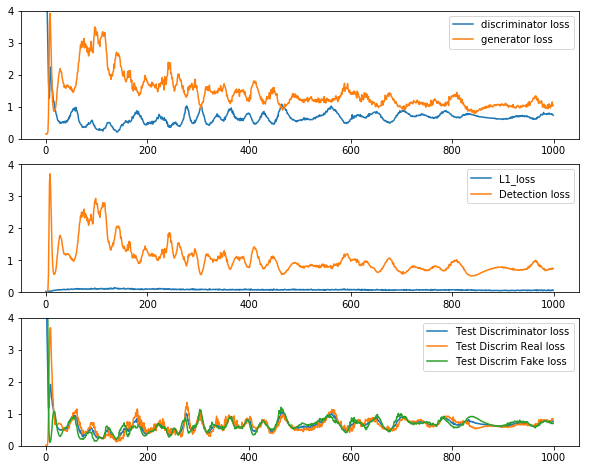

In [245]:
plot_loss(losses,**{'scale_control':[0,4]})

In [28]:
losses['g']

[[0.19565932, 0.03910265, 0.00014607016],
 [0.19676812, 0.03926825, 0.0004268565],
 [0.1884742, 0.037478205, 0.0010831687],
 [0.16662814, 0.03260755, 0.0035903803],
 [0.18088707, 0.031876974, 0.021502193],
 [0.28211156, 0.030182045, 0.13120133],
 [0.9299238, 0.03290117, 0.76541793],
 [1.7135847, 0.032498904, 1.5510901],
 [2.6745691, 0.03504776, 2.4993303],
 [3.0512757, 0.0343108, 2.8797216],
 [3.3157187, 0.03786823, 3.1263776],
 [2.9501524, 0.04214506, 2.739427],
 [2.787324, 0.046309948, 2.5557742],
 [2.204813, 0.04756543, 1.966986],
 [1.9490851, 0.047766678, 1.7102517],
 [1.525865, 0.056074835, 1.2454908],
 [1.4268372, 0.06334402, 1.1101172],
 [1.2187705, 0.06599647, 0.88878816],
 [1.1837777, 0.064739294, 0.8600812],
 [1.1033096, 0.06499094, 0.778355],
 [1.1675045, 0.0753528, 0.79074055],
 [1.2468212, 0.07214852, 0.88607866],
 [1.4939398, 0.086755805, 1.0601608],
 [1.4939542, 0.07881902, 1.099859],
 [1.7980915, 0.08377128, 1.3792351],
 [1.8508976, 0.07895656, 1.4561148],
 [2.239612, 0

In [29]:
y_hat=Discrim.predict(np.concatenate((x_test,y_test),axis=1))
y_idx = np.argmax(y_hat,axis=1)
print(sum(y_idx==1)/y_idx.shape[0])

0.6615384615384615


In [22]:
from fake_financial import make_fake_data

In [31]:
x_fake=make_fake_data(np.concatenate((x_test,y_test),axis=1),idx_test,ds,num_fakes=780,method='hard',var_scale=0.2)
y_hat=Discrim.predict(x_fake)
y_idx = np.argmax(y_hat,axis=1)
sum(y_idx==1)/y_idx.shape[0]

0.16025641025641027

In [223]:
Generator.predict([x_test,y_test])

array([[ 1.0216036 ,  1.0306793 , -0.03991554, ...,  0.23706846,
         0.1300222 ,  0.        ],
       [ 0.78292197,  1.120053  ,  0.28630668, ..., -0.24468584,
         0.08911397,  0.00972377],
       [ 1.3001981 ,  1.0662241 ,  0.01085235, ..., -0.06859834,
         0.31551692,  0.        ],
       ...,
       [ 1.0520463 ,  1.0384607 ,  0.03267045, ...,  0.06707437,
         0.21670657,  0.        ],
       [ 0.8394846 ,  0.90966994,  0.07169162, ...,  0.05553441,
         0.01587841,  0.01870261],
       [ 0.8445216 ,  1.0213993 ,  0.07306911, ...,  0.18447748,
         0.07283857,  0.        ]], dtype=float32)

In [25]:
import pandas as pd
i=64
composed_imgs=Generator.predict([x_test,y_test])
idx=np.hstack(('Revenues',cols[0:199]))
orig=np.hstack((y_test[i],x_test[i,:]))
fakes=np.hstack((composed_imgs[i][-1],composed_imgs[i][0:-1]))
#orig[orig!=0]
#pd.DataFrame({'originals':orig[orig!=0],'fakes':fakes[orig!=0]},index=idx[orig!=0])
df=pd.DataFrame({'originals':orig,'fakes':fakes},index=idx)
df[df.originals!=0]

,fakes,originals
Revenues,0.000738,0.000738
Assets,1.219557,1.363987
pAssets,0.998183,1.000000
pCashAndCashEquivalentsAtCarryingValue,0.233018,0.371226
CashAndCashEquivalentsAtCarryingValue,0.333154,0.254667
LiabilitiesAndStockholdersEquity,1.345067,1.363987
pLiabilitiesAndStockholdersEquity,0.980554,1.000000
NetIncomeLoss,0.108406,0.071316
pNetIncomeLoss,0.203413,0.395014
pStockholdersEquity,0.744827,0.852010


In [18]:
losses=train_for_n_mono(**train_dic)

  0%|          | 0/1000 [00:00<?, ?it/s]

64/64 [==============================] - 0s 36us/step


  0%|          | 1/1000 [00:01<28:44,  1.73s/it]

64/64 [==============================] - 0s 32us/step


  1%|          | 6/1000 [00:01<05:05,  3.25it/s]

64/64 [==============================] - 0s 51us/step


  1%|          | 11/1000 [00:01<02:56,  5.60it/s]

64/64 [==============================] - 0s 66us/step


  2%|▏         | 16/1000 [00:02<02:07,  7.70it/s]

64/64 [==============================] - 0s 37us/step


  2%|▏         | 21/1000 [00:02<01:42,  9.58it/s]

64/64 [==============================] - 0s 48us/step


  3%|▎         | 26/1000 [00:02<01:26, 11.28it/s]

64/64 [==============================] - 0s 28us/step


  3%|▎         | 31/1000 [00:02<01:15, 12.80it/s]

64/64 [==============================] - 0s 34us/step


  4%|▎         | 36/1000 [00:02<01:07, 14.23it/s]

64/64 [==============================] - 0s 49us/step


  4%|▍         | 41/1000 [00:02<01:01, 15.56it/s]

64/64 [==============================] - 0s 48us/step


  5%|▍         | 46/1000 [00:02<00:56, 16.79it/s]

64/64 [==============================] - 0s 38us/step


  5%|▌         | 51/1000 [00:02<00:53, 17.89it/s]

64/64 [==============================] - 0s 54us/step


  6%|▌         | 56/1000 [00:02<00:49, 18.97it/s]

64/64 [==============================] - 0s 42us/step


  6%|▌         | 61/1000 [00:03<00:47, 19.93it/s]

64/64 [==============================] - 0s 45us/step


  7%|▋         | 66/1000 [00:03<00:44, 20.84it/s]

64/64 [==============================] - 0s 31us/step


  7%|▋         | 71/1000 [00:03<00:42, 21.70it/s]

64/64 [==============================] - 0s 49us/step


  8%|▊         | 76/1000 [00:03<00:41, 22.49it/s]

64/64 [==============================] - 0s 39us/step


  8%|▊         | 81/1000 [00:03<00:39, 23.23it/s]

64/64 [==============================] - 0s 33us/step


  9%|▊         | 86/1000 [00:03<00:38, 23.96it/s]

64/64 [==============================] - 0s 47us/step


  9%|▉         | 91/1000 [00:03<00:36, 24.63it/s]

64/64 [==============================] - 0s 64us/step


 10%|▉         | 96/1000 [00:03<00:35, 25.27it/s]

64/64 [==============================] - 0s 33us/step


 10%|█         | 101/1000 [00:03<00:34, 25.79it/s]

64/64 [==============================] - 0s 30us/step


 11%|█         | 106/1000 [00:04<00:33, 26.34it/s]

64/64 [==============================] - 0s 39us/step


 11%|█         | 111/1000 [00:04<00:33, 26.81it/s]

64/64 [==============================] - 0s 29us/step


 12%|█▏        | 116/1000 [00:04<00:32, 27.32it/s]

64/64 [==============================] - 0s 38us/step


 12%|█▏        | 121/1000 [00:04<00:31, 27.80it/s]

64/64 [==============================] - 0s 61us/step


 13%|█▎        | 126/1000 [00:04<00:30, 28.24it/s]

64/64 [==============================] - 0s 43us/step


 13%|█▎        | 131/1000 [00:04<00:30, 28.64it/s]

64/64 [==============================] - 0s 38us/step


 14%|█▎        | 136/1000 [00:04<00:29, 29.09it/s]

64/64 [==============================] - 0s 31us/step


 14%|█▍        | 141/1000 [00:04<00:29, 29.52it/s]

64/64 [==============================] - 0s 28us/step


 15%|█▍        | 146/1000 [00:04<00:28, 29.92it/s]

64/64 [==============================] - 0s 28us/step


 15%|█▌        | 151/1000 [00:04<00:28, 30.29it/s]

64/64 [==============================] - 0s 30us/step


 16%|█▌        | 156/1000 [00:05<00:27, 30.66it/s]

64/64 [==============================] - 0s 27us/step


 16%|█▌        | 161/1000 [00:05<00:27, 30.94it/s]

64/64 [==============================] - 0s 42us/step


 17%|█▋        | 166/1000 [00:05<00:26, 31.25it/s]

64/64 [==============================] - 0s 53us/step


 17%|█▋        | 172/1000 [00:05<00:26, 31.68it/s]

64/64 [==============================] - 0s 37us/step


 18%|█▊        | 177/1000 [00:05<00:25, 31.94it/s]

64/64 [==============================] - 0s 62us/step


 18%|█▊        | 182/1000 [00:05<00:25, 32.20it/s]

64/64 [==============================] - 0s 48us/step


 19%|█▊        | 187/1000 [00:05<00:25, 32.46it/s]

64/64 [==============================] - 0s 27us/step


 19%|█▉        | 192/1000 [00:05<00:24, 32.69it/s]

64/64 [==============================] - 0s 47us/step


 20%|█▉        | 197/1000 [00:05<00:24, 32.91it/s]

64/64 [==============================] - 0s 36us/step


 20%|██        | 202/1000 [00:06<00:24, 33.12it/s]

64/64 [==============================] - 0s 29us/step


 21%|██        | 207/1000 [00:06<00:23, 33.27it/s]

64/64 [==============================] - 0s 46us/step


 21%|██        | 212/1000 [00:06<00:23, 33.44it/s]

64/64 [==============================] - 0s 43us/step


 22%|██▏       | 217/1000 [00:06<00:23, 33.63it/s]

64/64 [==============================] - 0s 35us/step


 22%|██▏       | 222/1000 [00:06<00:22, 33.84it/s]

64/64 [==============================] - 0s 57us/step


 23%|██▎       | 227/1000 [00:06<00:22, 33.99it/s]

64/64 [==============================] - 0s 25us/step


 23%|██▎       | 232/1000 [00:06<00:22, 34.17it/s]

64/64 [==============================] - 0s 25us/step


 24%|██▍       | 238/1000 [00:06<00:22, 34.46it/s]

64/64 [==============================] - 0s 50us/step


 24%|██▍       | 243/1000 [00:07<00:21, 34.65it/s]

64/64 [==============================] - 0s 31us/step


 25%|██▍       | 248/1000 [00:07<00:21, 34.77it/s]

64/64 [==============================] - 0s 84us/step


 25%|██▌       | 253/1000 [00:07<00:21, 34.90it/s]

64/64 [==============================] - 0s 31us/step


 26%|██▌       | 258/1000 [00:07<00:21, 35.08it/s]

64/64 [==============================] - 0s 34us/step


 26%|██▋       | 263/1000 [00:07<00:20, 35.21it/s]

64/64 [==============================] - 0s 50us/step


 27%|██▋       | 268/1000 [00:07<00:20, 35.36it/s]

64/64 [==============================] - 0s 35us/step


 27%|██▋       | 273/1000 [00:07<00:20, 35.51it/s]

64/64 [==============================] - 0s 35us/step


 28%|██▊       | 278/1000 [00:07<00:20, 35.65it/s]

64/64 [==============================] - 0s 30us/step


 28%|██▊       | 283/1000 [00:07<00:20, 35.79it/s]

64/64 [==============================] - 0s 51us/step


 29%|██▉       | 288/1000 [00:08<00:19, 35.92it/s]

64/64 [==============================] - 0s 58us/step


 29%|██▉       | 293/1000 [00:08<00:19, 36.04it/s]

64/64 [==============================] - 0s 46us/step


 30%|██▉       | 298/1000 [00:08<00:19, 36.17it/s]

64/64 [==============================] - 0s 32us/step


 30%|███       | 303/1000 [00:08<00:19, 36.27it/s]

64/64 [==============================] - 0s 57us/step


 31%|███       | 308/1000 [00:08<00:19, 36.37it/s]

64/64 [==============================] - 0s 133us/step


 31%|███▏      | 313/1000 [00:08<00:18, 36.46it/s]

64/64 [==============================] - 0s 43us/step


 32%|███▏      | 318/1000 [00:08<00:18, 36.58it/s]

64/64 [==============================] - 0s 45us/step


 32%|███▏      | 323/1000 [00:08<00:18, 36.68it/s]

64/64 [==============================] - 0s 43us/step


 33%|███▎      | 328/1000 [00:08<00:18, 36.81it/s]

64/64 [==============================] - 0s 40us/step


 33%|███▎      | 333/1000 [00:09<00:18, 36.95it/s]

64/64 [==============================] - 0s 26us/step


 34%|███▍      | 338/1000 [00:09<00:17, 37.09it/s]

64/64 [==============================] - 0s 29us/step


 34%|███▍      | 343/1000 [00:09<00:17, 37.22it/s]

64/64 [==============================] - 0s 27us/step


 35%|███▍      | 348/1000 [00:09<00:17, 37.32it/s]

64/64 [==============================] - 0s 29us/step


 35%|███▌      | 353/1000 [00:09<00:17, 37.40it/s]

64/64 [==============================] - 0s 32us/step


 36%|███▌      | 358/1000 [00:09<00:17, 37.51it/s]

64/64 [==============================] - 0s 35us/step


 36%|███▋      | 363/1000 [00:09<00:16, 37.63it/s]

64/64 [==============================] - 0s 63us/step


 37%|███▋      | 368/1000 [00:09<00:16, 37.75it/s]

64/64 [==============================] - 0s 32us/step


 37%|███▋      | 373/1000 [00:09<00:16, 37.86it/s]

64/64 [==============================] - 0s 29us/step


 38%|███▊      | 378/1000 [00:09<00:16, 37.98it/s]

64/64 [==============================] - 0s 105us/step


 38%|███▊      | 383/1000 [00:10<00:16, 38.05it/s]

64/64 [==============================] - 0s 39us/step


 39%|███▉      | 388/1000 [00:10<00:16, 38.16it/s]

64/64 [==============================] - 0s 43us/step


 39%|███▉      | 393/1000 [00:10<00:15, 38.26it/s]

64/64 [==============================] - 0s 28us/step


 40%|███▉      | 398/1000 [00:10<00:15, 38.36it/s]

64/64 [==============================] - 0s 43us/step


 40%|████      | 403/1000 [00:10<00:15, 38.46it/s]

64/64 [==============================] - 0s 30us/step


 41%|████      | 408/1000 [00:10<00:15, 38.57it/s]

64/64 [==============================] - 0s 56us/step


 41%|████▏     | 413/1000 [00:10<00:15, 38.64it/s]

64/64 [==============================] - 0s 67us/step


 42%|████▏     | 418/1000 [00:10<00:15, 38.71it/s]

64/64 [==============================] - 0s 35us/step


 42%|████▏     | 423/1000 [00:10<00:14, 38.77it/s]

64/64 [==============================] - 0s 55us/step


 43%|████▎     | 428/1000 [00:11<00:14, 38.83it/s]

64/64 [==============================] - 0s 49us/step


 43%|████▎     | 433/1000 [00:11<00:14, 38.91it/s]

64/64 [==============================] - 0s 56us/step


 44%|████▍     | 438/1000 [00:11<00:14, 38.96it/s]

64/64 [==============================] - 0s 38us/step


 44%|████▍     | 443/1000 [00:11<00:14, 38.99it/s]

64/64 [==============================] - 0s 48us/step


 45%|████▍     | 448/1000 [00:11<00:14, 39.06it/s]

64/64 [==============================] - 0s 55us/step


 45%|████▌     | 453/1000 [00:11<00:13, 39.12it/s]

64/64 [==============================] - 0s 37us/step


 46%|████▌     | 458/1000 [00:11<00:13, 39.18it/s]

64/64 [==============================] - 0s 31us/step


 46%|████▋     | 463/1000 [00:11<00:13, 39.26it/s]

64/64 [==============================] - 0s 38us/step


 47%|████▋     | 468/1000 [00:11<00:13, 39.32it/s]

64/64 [==============================] - 0s 104us/step


 47%|████▋     | 473/1000 [00:12<00:13, 39.37it/s]

64/64 [==============================] - 0s 42us/step


 48%|████▊     | 478/1000 [00:12<00:13, 39.42it/s]

64/64 [==============================] - 0s 59us/step


 48%|████▊     | 483/1000 [00:12<00:13, 39.49it/s]

64/64 [==============================] - 0s 44us/step


 49%|████▉     | 488/1000 [00:12<00:12, 39.56it/s]

64/64 [==============================] - 0s 29us/step


 49%|████▉     | 493/1000 [00:12<00:12, 39.63it/s]

64/64 [==============================] - 0s 30us/step


 50%|████▉     | 498/1000 [00:12<00:12, 39.67it/s]

64/64 [==============================] - 0s 48us/step


 50%|█████     | 503/1000 [00:12<00:12, 39.70it/s]

64/64 [==============================] - 0s 56us/step


 51%|█████     | 508/1000 [00:12<00:12, 39.74it/s]

64/64 [==============================] - 0s 43us/step


 51%|█████▏    | 513/1000 [00:12<00:12, 39.75it/s]

64/64 [==============================] - 0s 57us/step


 52%|█████▏    | 518/1000 [00:13<00:12, 39.80it/s]

64/64 [==============================] - 0s 62us/step


 52%|█████▏    | 523/1000 [00:13<00:11, 39.84it/s]

64/64 [==============================] - 0s 118us/step


 53%|█████▎    | 528/1000 [00:13<00:11, 39.85it/s]

64/64 [==============================] - 0s 46us/step


 53%|█████▎    | 533/1000 [00:13<00:11, 39.86it/s]

64/64 [==============================] - 0s 36us/step


 54%|█████▍    | 538/1000 [00:13<00:11, 39.93it/s]

64/64 [==============================] - 0s 49us/step


 54%|█████▍    | 543/1000 [00:13<00:11, 39.98it/s]

64/64 [==============================] - 0s 28us/step


 55%|█████▍    | 548/1000 [00:13<00:11, 40.04it/s]

64/64 [==============================] - 0s 45us/step


 55%|█████▌    | 553/1000 [00:13<00:11, 40.09it/s]

64/64 [==============================] - 0s 46us/step


 56%|█████▌    | 558/1000 [00:13<00:11, 40.16it/s]

64/64 [==============================] - 0s 32us/step


 56%|█████▋    | 563/1000 [00:13<00:10, 40.22it/s]

64/64 [==============================] - 0s 32us/step


 57%|█████▋    | 568/1000 [00:14<00:10, 40.27it/s]

64/64 [==============================] - 0s 32us/step


 57%|█████▋    | 573/1000 [00:14<00:10, 40.34it/s]

64/64 [==============================] - 0s 33us/step


 58%|█████▊    | 578/1000 [00:14<00:10, 40.39it/s]

64/64 [==============================] - 0s 45us/step


 58%|█████▊    | 583/1000 [00:14<00:10, 40.43it/s]

64/64 [==============================] - 0s 31us/step


 59%|█████▉    | 588/1000 [00:14<00:10, 40.49it/s]

64/64 [==============================] - 0s 32us/step


 59%|█████▉    | 593/1000 [00:14<00:10, 40.51it/s]

64/64 [==============================] - 0s 36us/step


 60%|█████▉    | 598/1000 [00:14<00:09, 40.57it/s]

64/64 [==============================] - 0s 32us/step


 60%|██████    | 603/1000 [00:14<00:09, 40.61it/s]

64/64 [==============================] - 0s 30us/step


 61%|██████    | 609/1000 [00:14<00:09, 40.68it/s]

64/64 [==============================] - 0s 49us/step


 61%|██████▏   | 614/1000 [00:15<00:09, 40.73it/s]

64/64 [==============================] - 0s 29us/step


 62%|██████▏   | 619/1000 [00:15<00:09, 40.79it/s]

64/64 [==============================] - 0s 37us/step


 62%|██████▏   | 624/1000 [00:15<00:09, 40.82it/s]

64/64 [==============================] - 0s 45us/step


 63%|██████▎   | 629/1000 [00:15<00:09, 40.85it/s]

64/64 [==============================] - 0s 42us/step


 63%|██████▎   | 634/1000 [00:15<00:08, 40.87it/s]

64/64 [==============================] - 0s 36us/step


 64%|██████▍   | 639/1000 [00:15<00:08, 40.91it/s]

64/64 [==============================] - 0s 42us/step


 64%|██████▍   | 644/1000 [00:15<00:08, 40.95it/s]

64/64 [==============================] - 0s 32us/step


 65%|██████▍   | 649/1000 [00:15<00:08, 41.01it/s]

64/64 [==============================] - 0s 56us/step


 65%|██████▌   | 654/1000 [00:15<00:08, 41.06it/s]

64/64 [==============================] - 0s 38us/step


 66%|██████▌   | 659/1000 [00:16<00:08, 41.10it/s]

64/64 [==============================] - 0s 29us/step


 66%|██████▋   | 664/1000 [00:16<00:08, 41.15it/s]

64/64 [==============================] - 0s 37us/step


 67%|██████▋   | 669/1000 [00:16<00:08, 41.20it/s]

64/64 [==============================] - 0s 53us/step


 67%|██████▋   | 674/1000 [00:16<00:07, 41.24it/s]

64/64 [==============================] - 0s 48us/step


 68%|██████▊   | 679/1000 [00:16<00:07, 41.27it/s]

64/64 [==============================] - 0s 61us/step


 68%|██████▊   | 684/1000 [00:16<00:07, 41.28it/s]

64/64 [==============================] - 0s 60us/step


 69%|██████▉   | 689/1000 [00:16<00:07, 41.28it/s]

64/64 [==============================] - 0s 27us/step


 69%|██████▉   | 694/1000 [00:16<00:07, 41.33it/s]

64/64 [==============================] - 0s 28us/step


 70%|██████▉   | 699/1000 [00:16<00:07, 41.35it/s]

64/64 [==============================] - 0s 53us/step


 70%|███████   | 704/1000 [00:17<00:07, 41.39it/s]

64/64 [==============================] - 0s 30us/step


 71%|███████   | 709/1000 [00:17<00:07, 41.42it/s]

64/64 [==============================] - 0s 45us/step


 71%|███████▏  | 714/1000 [00:17<00:06, 41.46it/s]

64/64 [==============================] - 0s 58us/step


 72%|███████▏  | 719/1000 [00:17<00:06, 41.49it/s]

64/64 [==============================] - 0s 42us/step


 72%|███████▏  | 724/1000 [00:17<00:06, 41.54it/s]

64/64 [==============================] - 0s 29us/step


 73%|███████▎  | 729/1000 [00:17<00:06, 41.57it/s]

64/64 [==============================] - 0s 30us/step


 73%|███████▎  | 734/1000 [00:17<00:06, 41.61it/s]

64/64 [==============================] - 0s 48us/step


 74%|███████▍  | 739/1000 [00:17<00:06, 41.64it/s]

64/64 [==============================] - 0s 64us/step


 74%|███████▍  | 744/1000 [00:17<00:06, 41.68it/s]

64/64 [==============================] - 0s 36us/step


 75%|███████▍  | 749/1000 [00:17<00:06, 41.71it/s]

64/64 [==============================] - 0s 29us/step


 75%|███████▌  | 754/1000 [00:18<00:05, 41.76it/s]

64/64 [==============================] - 0s 50us/step


 76%|███████▌  | 759/1000 [00:18<00:05, 41.79it/s]

64/64 [==============================] - 0s 44us/step


 76%|███████▋  | 764/1000 [00:18<00:05, 41.81it/s]

64/64 [==============================] - 0s 37us/step


 77%|███████▋  | 769/1000 [00:18<00:05, 41.82it/s]

64/64 [==============================] - 0s 29us/step


 77%|███████▋  | 774/1000 [00:18<00:05, 41.86it/s]

64/64 [==============================] - 0s 28us/step


 78%|███████▊  | 779/1000 [00:18<00:05, 41.90it/s]

64/64 [==============================] - 0s 29us/step


 78%|███████▊  | 784/1000 [00:18<00:05, 41.93it/s]

64/64 [==============================] - 0s 44us/step


 79%|███████▉  | 789/1000 [00:18<00:05, 41.96it/s]

64/64 [==============================] - 0s 37us/step


 79%|███████▉  | 794/1000 [00:18<00:04, 41.99it/s]

64/64 [==============================] - 0s 42us/step


 80%|███████▉  | 799/1000 [00:19<00:04, 42.02it/s]

64/64 [==============================] - 0s 45us/step


 80%|████████  | 804/1000 [00:19<00:04, 42.04it/s]

64/64 [==============================] - 0s 39us/step


 81%|████████  | 809/1000 [00:19<00:04, 42.07it/s]

64/64 [==============================] - 0s 50us/step


 81%|████████▏ | 814/1000 [00:19<00:04, 42.09it/s]

64/64 [==============================] - 0s 65us/step


 82%|████████▏ | 819/1000 [00:19<00:04, 42.10it/s]

64/64 [==============================] - 0s 32us/step


 82%|████████▏ | 824/1000 [00:19<00:04, 42.13it/s]

64/64 [==============================] - 0s 36us/step


 83%|████████▎ | 829/1000 [00:19<00:04, 42.15it/s]

64/64 [==============================] - 0s 38us/step


 83%|████████▎ | 834/1000 [00:19<00:03, 42.18it/s]

64/64 [==============================] - 0s 43us/step


 84%|████████▍ | 839/1000 [00:19<00:03, 42.21it/s]

64/64 [==============================] - 0s 43us/step


 84%|████████▍ | 844/1000 [00:19<00:03, 42.24it/s]

64/64 [==============================] - 0s 33us/step


 85%|████████▌ | 850/1000 [00:20<00:03, 42.29it/s]

64/64 [==============================] - 0s 51us/step


 86%|████████▌ | 855/1000 [00:20<00:03, 42.31it/s]

64/64 [==============================] - 0s 31us/step


 86%|████████▌ | 860/1000 [00:20<00:03, 42.34it/s]

64/64 [==============================] - 0s 56us/step


 86%|████████▋ | 865/1000 [00:20<00:03, 42.35it/s]

64/64 [==============================] - 0s 44us/step


 87%|████████▋ | 870/1000 [00:20<00:03, 42.37it/s]

64/64 [==============================] - 0s 28us/step


 88%|████████▊ | 875/1000 [00:20<00:02, 42.39it/s]

64/64 [==============================] - 0s 51us/step


 88%|████████▊ | 880/1000 [00:20<00:02, 42.40it/s]

64/64 [==============================] - 0s 48us/step


 88%|████████▊ | 885/1000 [00:20<00:02, 42.42it/s]

64/64 [==============================] - 0s 37us/step


 89%|████████▉ | 890/1000 [00:20<00:02, 42.45it/s]

64/64 [==============================] - 0s 28us/step


 90%|████████▉ | 895/1000 [00:21<00:02, 42.47it/s]

64/64 [==============================] - 0s 31us/step


 90%|█████████ | 900/1000 [00:21<00:02, 42.48it/s]

64/64 [==============================] - 0s 45us/step


 90%|█████████ | 905/1000 [00:21<00:02, 42.50it/s]

64/64 [==============================] - 0s 44us/step


 91%|█████████ | 910/1000 [00:21<00:02, 42.52it/s]

64/64 [==============================] - 0s 53us/step


 92%|█████████▏| 915/1000 [00:21<00:01, 42.54it/s]

64/64 [==============================] - 0s 33us/step


 92%|█████████▏| 920/1000 [00:21<00:01, 42.57it/s]

64/64 [==============================] - 0s 49us/step


 92%|█████████▎| 925/1000 [00:21<00:01, 42.59it/s]

64/64 [==============================] - 0s 42us/step


 93%|█████████▎| 930/1000 [00:21<00:01, 42.61it/s]

64/64 [==============================] - 0s 53us/step


 94%|█████████▎| 935/1000 [00:21<00:01, 42.63it/s]

64/64 [==============================] - 0s 39us/step


 94%|█████████▍| 940/1000 [00:22<00:01, 42.65it/s]

64/64 [==============================] - 0s 29us/step


 94%|█████████▍| 945/1000 [00:22<00:01, 42.68it/s]

64/64 [==============================] - 0s 55us/step


 95%|█████████▌| 950/1000 [00:22<00:01, 42.70it/s]

64/64 [==============================] - 0s 43us/step


 96%|█████████▌| 955/1000 [00:22<00:01, 42.70it/s]

64/64 [==============================] - 0s 44us/step


 96%|█████████▌| 960/1000 [00:22<00:00, 42.73it/s]

64/64 [==============================] - 0s 42us/step


 96%|█████████▋| 965/1000 [00:22<00:00, 42.75it/s]

64/64 [==============================] - 0s 28us/step


 97%|█████████▋| 970/1000 [00:22<00:00, 42.76it/s]

64/64 [==============================] - 0s 54us/step


 98%|█████████▊| 975/1000 [00:22<00:00, 42.78it/s]

64/64 [==============================] - 0s 46us/step


 98%|█████████▊| 980/1000 [00:22<00:00, 42.81it/s]

64/64 [==============================] - 0s 35us/step


 98%|█████████▊| 985/1000 [00:22<00:00, 42.83it/s]

64/64 [==============================] - 0s 45us/step


 99%|█████████▉| 990/1000 [00:23<00:00, 42.85it/s]

64/64 [==============================] - 0s 45us/step


100%|█████████▉| 995/1000 [00:23<00:00, 42.87it/s]

64/64 [==============================] - 0s 39us/step


100%|██████████| 1000/1000 [00:23<00:00, 42.89it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

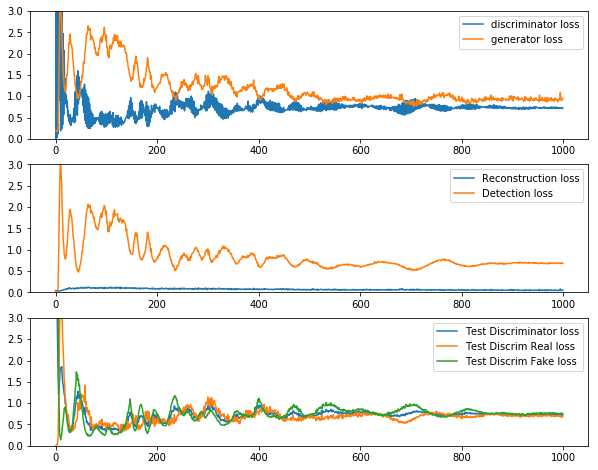

In [26]:
plot_loss(losses,**{'scale_control':[0,3]})